In [27]:
import os

import abc
import matplotlib.pyplot as plt
import numpy as np

o_path = os.getcwd()
root_folder_path = os.path.abspath(os.path.join(o_path,os.path.pardir))

class Analyzer(metaclass = abc.ABCMeta): 
    def __init__(self): 
        self._data = {}
        # 开关
        self._condiation = False
        # 终止
        self._hasdone = False

    def setLine(self, strline):
        self._line = strline

    @abc.abstractmethod
    def cond(self): 
        return self._condiation

    @abc.abstractmethod
    def process(self): 
        pass

    def getData(self): 
        return self._data

class BaseInfoAnalyzer(Analyzer):
    def __init__(self):
        super().__init__()
        self.line_key = [
            'Loaded word vocab. size: ',
            'Loaded target word vocab. size: ',
            'Loaded paths vocab. size: ']
    
    def cond(self):
        if not self._hasdone:
            if self._line == 'Dictionaries loaded.':
                self._condiation = True
            if self._condiation and self._line == 'Created model':
                self._condiation = False
                self._hasdone = True
        else:
            pass
        return self._condiation

    def process(self):
        for i in range(len(self.line_key)):
            if self._line.find(self.line_key[i]) >= 0:
                self._data[self.line_key[i]] = int(self._line[self._line.rfind(' ')+1:])

class SingleLineAnalyzer(Analyzer):
    def __init__(self):
        super().__init__()
        self.line_key = [
            'Training time: '
            ]
    
    def cond(self):
        if self._line == 'Reader stopping':
            self._condiation = True
        return self._condiation

    def process(self):
        for i in range(len(self.line_key)):
            if self._line.find(self.line_key[i]) >= 0:
                # Training time: 2H:10M:16S
                if i == 0:
                    line_values = self._line.strip().split(' ')
                    traing_time = line_values[2]
                    self._data[self.line_key[i]] = traing_time

class TrainInfoAnalyzer(Analyzer):
    def __init__(self):
        super().__init__()
        self.line_key = [
            'Average loss at batch ',
            ' epochs: Precision: ',
            ]
        self._average_loss_at_batch_list = []
        self._roc_at_batch_list = []

        self._data[self.line_key[0]] = self._average_loss_at_batch_list
        self._data[self.line_key[1]] = self._roc_at_batch_list

    
    def cond(self):
        if not self._hasdone:
            if self._line == 'Started reader...':
                self._condiation = True
            if self._condiation and self._line == 'Reader stopping':
                self._condiation = False
                self._hasdone = True
        else:
            pass
        return self._condiation

    def process(self):
        for i in range(len(self.line_key)):
            idx = self._line.find(self.line_key[i]) 
            if idx >= 0:
                # Average loss at batch 600: 0.009521,
                if i == 0:
                    idx_token_maohao = self._line.find(':', idx + len(self.line_key[i]), len(self._line))
                    idx_token_douhao = self._line.find(',', idx_token_maohao, len(self._line)) 
                    batch_time = int(self._line[len(self.line_key[i]) : idx_token_maohao])
                    average_loss = float(self._line[idx_token_maohao+2 : idx_token_douhao])
                    self._average_loss_at_batch_list.append([batch_time, average_loss])
                # After 1 epochs: Precision: 0.14367562802996914, recall: 0.04272888131594469, F1: 0.065868565944335
                elif i == 1:
                    line_values = self._line.strip().split(' ')
                    epochs = int(line_values[1])
                    precision = float(line_values[4].rstrip(','))
                    recall = float(line_values[6].rstrip(','))
                    f1 = float(line_values[8])
                    batch_time,_ = self._average_loss_at_batch_list[-1]
                    self._roc_at_batch_list.append([batch_time, epochs, precision, recall, f1])


class LogAnalyze:
    def __init__(self, file_path, analyzer_list):
        self._file_path = file_path
        self._analyzer_list = analyzer_list
    
    def run(self):
        if not os.path.exists(self._file_path):
            return None
        if len(self._analyzer_list) == 0:
            return None

        with open(self._file_path, 'r') as file:
            for line in file:
                line = line.strip()
                for analyzer in self._analyzer_list:
                    analyzer.setLine(line)
                    if analyzer.cond():
                        analyzer.process()


In [21]:
analyzer_list = []

bi_ana = BaseInfoAnalyzer()
ti_ana= TrainInfoAnalyzer()
single_ana = SingleLineAnalyzer()

analyzer_list.append(bi_ana)
analyzer_list.append(ti_ana)
analyzer_list.append(single_ana)

log_file = os.path.join(root_folder_path, 'train_log/plot.txt')
la = LogAnalyze(log_file,analyzer_list)
la.run()
print(analyzer_list[0].getData().keys())

dict_keys(['Loaded word vocab. size: ', 'Loaded target word vocab. size: ', 'Loaded paths vocab. size: '])


In [12]:
analyzer_list[0].getData()

{'Loaded word vocab. size: ': 1037257,
 'Loaded target word vocab. size: ': 195341,
 'Loaded paths vocab. size: ': 684532}

In [13]:
analyzer_list[1].getData()

{'Average loss at batch ': [[100, 0.011379],
  [200, 0.010665],
  [300, 0.010406],
  [400, 0.010145],
  [500, 0.009931],
  [600, 0.009764],
  [700, 0.009587],
  [800, 0.009409],
  [900, 0.009212],
  [1000, 0.00902],
  [1100, 0.008858],
  [1200, 0.008714],
  [1300, 0.00853],
  [1400, 0.00834],
  [1500, 0.008189],
  [1600, 0.00807],
  [1700, 0.007912],
  [1800, 0.00776],
  [1900, 0.0076],
  [2000, 0.007468],
  [2100, 0.00732],
  [2200, 0.007179],
  [2300, 0.007073],
  [2400, 0.006919],
  [2500, 0.006801],
  [2600, 0.00669],
  [2700, 0.006545],
  [2800, 0.006463],
  [2900, 0.006339],
  [3000, 0.006236],
  [3100, 0.006142],
  [3200, 0.006031],
  [3300, 0.005913],
  [3400, 0.005809],
  [3500, 0.005745],
  [3600, 0.005664],
  [3700, 0.005538],
  [3800, 0.005451],
  [3900, 0.005362],
  [4000, 0.005292],
  [4100, 0.005215],
  [4200, 0.00511],
  [4300, 0.005039],
  [4400, 0.004967],
  [4500, 0.004907],
  [4600, 0.004823],
  [4700, 0.004751],
  [4800, 0.004671],
  [4900, 0.004596],
  [5000, 0.00

In [14]:
analyzer_list[2].getData()

{'Training time: ': '2H:10M:16S'}

In [283]:
def randline(base, k=0.2, d =1.3):
    result = base.copy()
    interval = base[1:]
    interval = interval - base[0:-1]
    interval = np.mean(interval)
    print(interval)
    for i in range(1, len(base)):
        result[i] = (1-k) * result[i-1] + k * base[i]
    result = (result + (np.random.random((base.shape[0],)) - 0.5) * interval) * (d + (np.random.random((base.shape[0],)) - 0.3) *interval)
    return result

In [284]:
arr_loss = np.array(analyzer_list[1].getData()['Average loss at batch '])
arr_roc = np.array(analyzer_list[1].getData()[' epochs: Precision: '])

x = arr[:, 0]
y = arr[:, 1]

x1 = x

y1 = y * 1.5

x_roc = arr_roc[:, 0]
y_roc_precision = arr_roc[:, 2]
y_roc_recall = arr_roc[:, 3]
y_roc_f1 = arr_roc[:, 4] * 1.4

x1_roc = x_roc
y1_roc_f1[0] = y_roc_f1[0] - 0.02
y1_roc_f1 = randline(y_roc_f1)
# for i in range(1, len(y_roc_f1)):
#     y1_roc_f1[i] = (1-k) * y1_roc_f1[i-1] + k * y_roc_f1[i]
# y1_roc_f1 = (y1_roc_f1 + (np.random.random((y_roc_recall.shape[0],)) - 0.5) / 100) * (1.2 + (np.random.random((y_roc_f1.shape[0],)) - 0.3) / 100)

0.010057417595503645


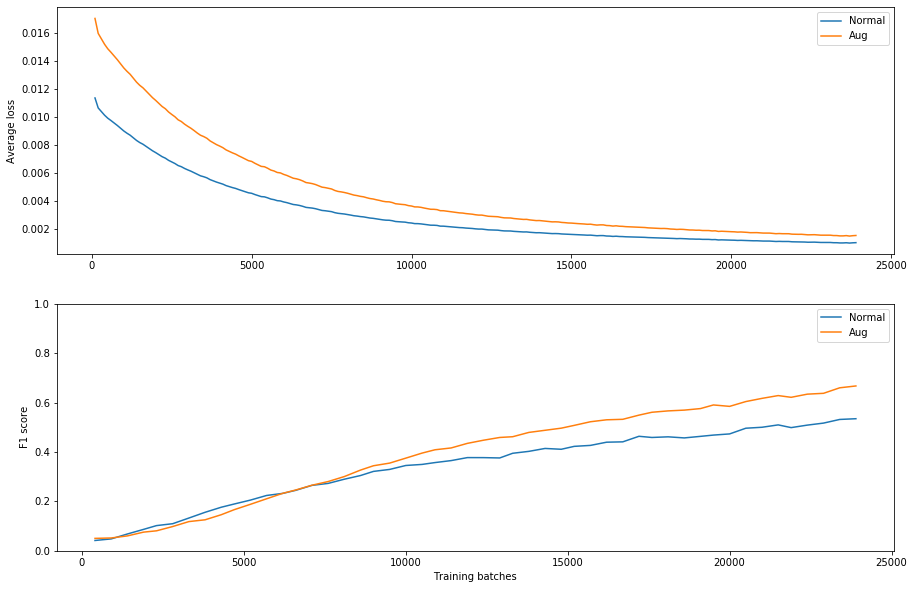

In [285]:
fig=plt.figure(figsize=(15,10)) 
ax1=fig.add_subplot(2,1,1) 
plt.plot(x, y, label='Normal')
plt.plot(x1, y1, label='Aug')
plt.ylabel('Average loss')
ax2 = fig.add_subplot(2,1,2) 
plt.plot(x_roc, y_roc_f1, label='Normal')
plt.plot(x1_roc, y1_roc_f1, label='Aug')
plt.ylim(0, 1)
plt.ylabel('F1 score')

plt.xlabel('Training batches')

ax1.legend(loc="best")
ax2.legend(loc="best")

In [289]:
y_roc_f1[-1], y1_roc_f1[-1]

(0.5345453884522409, 0.6671171908155987)

In [290]:
(y1_roc_f1[-1] -  y_roc_f1[-1] )/ y_roc_f1[-1] * 100

24.800850447370856